In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.constants import c as speed_of_light
from scipy.integrate import simpson 
from tqdm import tqdm
import prodimopy.read as pread

In [2]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / (wl * 1e-4) ** 2) * flux_nu * 1e-23
    tot_flux = simpson(flux_lambda, (wl * 1e-4))
    return tot_flux


def plot_prodimo_specie(df, specie, xrange=[5, 28], num_xticks=5, yrange=[0, 0.02], num_yticks=5, savename=None):
    '''
    Plots the spectrum of a specific specie for all the models
    '''
    fig = plt.figure(figsize=(14, 14))
    gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row').flatten()
    for i, row in df.iterrows():
        n_row, n_col = divmod(i, 5)
        axes[i].plot(row['Prodimo Wavelength'], row[specie], label=row['Model Name'])
        axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.8,
                     f"C={row['C Value']} O={row['O Value']} CO={row['CO Value']} \nFlux={total_flux(row['Prodimo Wavelength'], row[specie]):.1e}",
                     fontsize=10, color='red',
                     weight='bold')
        axes[i].set_xlim(xrange)
        axes[i].set_ylim(yrange)
        if n_row == 4:
            axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
            axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
            axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        if n_col == 0:
            axes[i].set_ylabel("Flux (Jy)")
            axes[i].set_yticks(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
            axes[i].set_yticklabels(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
    fig.suptitle(specie, fontsize=30, fontweight='bold', y=1.02)
    plt.tight_layout()
    if savename:
        plt.savefig(savename)
    plt.show()


def plot_FLiTs_spec(df, xrange=[5, 28], num_xticks=5, yrange=[0, 0.12], num_yticks=5, savename=None):
    '''
    Plots the spectrum of a specific specie for all the models
    '''
    fig = plt.figure(figsize=(13, 13))
    gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row').flatten()
    for i, row in df.iterrows():
        n_row, n_col = divmod(i, 5)
        axes[i].plot(row['FLiTs Wavelength'], row['FLiTs Flux'], label=row['Model Name'])
        axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.8,
                     f"C={row['C Value']} O={row['O Value']} C/O={row['CO Value']}",
                     fontsize=10, color='red',
                     weight='bold')
        axes[i].set_xlim(xrange)
        axes[i].set_ylim(yrange)
        if n_row == 4:
            axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
            axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
            axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        if n_col == 0:
            axes[i].set_ylabel("Flux (Jy)")
            axes[i].set_yticks(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
            axes[i].set_yticklabels(np.linspace(yrange[0] * 1000, yrange[1] * 1000, num_yticks, dtype=int)[:-1] / 1000)
    plt.tight_layout()
    if savename:
        plt.savefig(savename)
    plt.show()


def plot_prodimo_spec(df, model,
                      species=['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'S', 'o-H2', 'o-H2O',
                               'p-H2', 'p-H2O',
                               'Ion'], xrange=[5, 28], yrange=[0, 0.04], plotFLiTs=False):
    """
    Plots the total spectrum predicted by prodimo
    """
    total_spec = None
    cmap = mpl.colormaps.get_cmap('tab20')
    fig, ax = plt.subplots(figsize=(14, 5))
    for index, specie in enumerate(species):
        if total_spec is None:
            total_spec = df.loc[df['Model Name'] == model, specie].values[0].copy()
        else:
            total_spec += df.loc[df['Model Name'] == model, specie].values[0].copy()
        ax.fill_between(df['Prodimo Wavelength'][0], 0, total_spec, label=specie, zorder=len(species) - index,
                        color=cmap(index / len(species)))
    if plotFLiTs:
        ax.plot(df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy(),
                df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy(), label='FLiTs', color='black',
                zorder=20)
    fig.suptitle(model)
    ax.set_ylabel('Flux [Jy]')
    ax.set_xlabel(r'Wavelength [$\mu$m]')
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    ax.legend(loc='best')
    plt.show()


def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])
    

In [3]:
# Open the data 
with open('ModelData.pkl', 'rb') as f:
    df = pickle.load(f)
df

,Model Name,C Value,O Value,CO Value,FLiTs Wavelength,FLiTs Flux,C2H2_H,CH4_H,CO,CO2_H,...,NH3_H,NO_H,OH,S,o-H2,o-H2O,p-H2,p-H2O,Ion,Prodimo Wavelength
0,C_-0.5_O_-0.5_CO_0.45,-0.5,-0.5,0.45,"[4.90216873, 4.90218508, 4.90220144, 4.9022177...","[9.290666707434392e-05, 9.36347640732027e-05, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009307341873190812, 0.0025946503251030473, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.3182986361250367e-05, 6.271616736556394e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.127702175923299e-12, 9.302042235317881e-12,...","[0.0006072437215763561, 0.00024041948122676117...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0534450587666916e-05, 3.427201656202331e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.0033311083581555, 5.004220385307899, 5.0051..."
1,C_-0.5_O_-0.25_CO_0.2570,-0.5,-0.25,0.2570,"[4.90218508, 4.90220144, 4.90221779, 4.9022341...","[0.00019233132506346617, 0.0001931775592640128...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.009973783312290348, 0.0027809342451176797, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.021365790505544e-05, 5.4997197290708864e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.99031410462638e-12, 9.052809811517313e-12, ...","[0.0011853354571049826, 0.0004579242968545003,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0001294487811110376, 7.316643402095595e-05,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.0033311083581555, 5.004220385307899, 5.0051..."
2,C_-0.5_O_0.0_CO_0.145,-0.5,0.0,0.145,"[4.90221779, 4.90222315, 4.9022395, 4.90225585...","[0.000367419622368359, 0.0003677125852135088, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.010834020451426084, 0.0030209004637909826, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.015830577918783e-05, 5.5698927053998686e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.816015805219838e-12, 8.736619423113606e-12,...","[0.0019911193383478683, 0.0007601854635763619,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00025050065800522476, 0.0001414151709777897...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.0033311083581555, 5.004220385307899, 5.0051..."
3,C_-0.5_O_0.25_CO_0.0813,-0.5,0.25,0.0813,"[4.9022395, 4.90225585, 4.9022722, 4.90228855,...","[0.0006806647851314573, 0.0006815528527352455,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01228869544251925, 0.0034253443431899017, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0628384870538627e-05, 5.7287956368761395e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.589684337019875e-12, 8.326036904054085e-12,...","[0.0030268137683525436, 0.0011618455790448627,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00045584957004399197, 0.0002568596002204396...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.0033311083581555, 5.004220385307899, 5.0051..."
4,C_-0.5_O_0.5_CO_0.045,-0.5,0.5,0.045,"[4.90225585, 4.9022722, 4.90228855, 4.90230491...","[0.001111040302178401, 0.001111295774154919, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01468535216319025, 0.004090423097041402, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

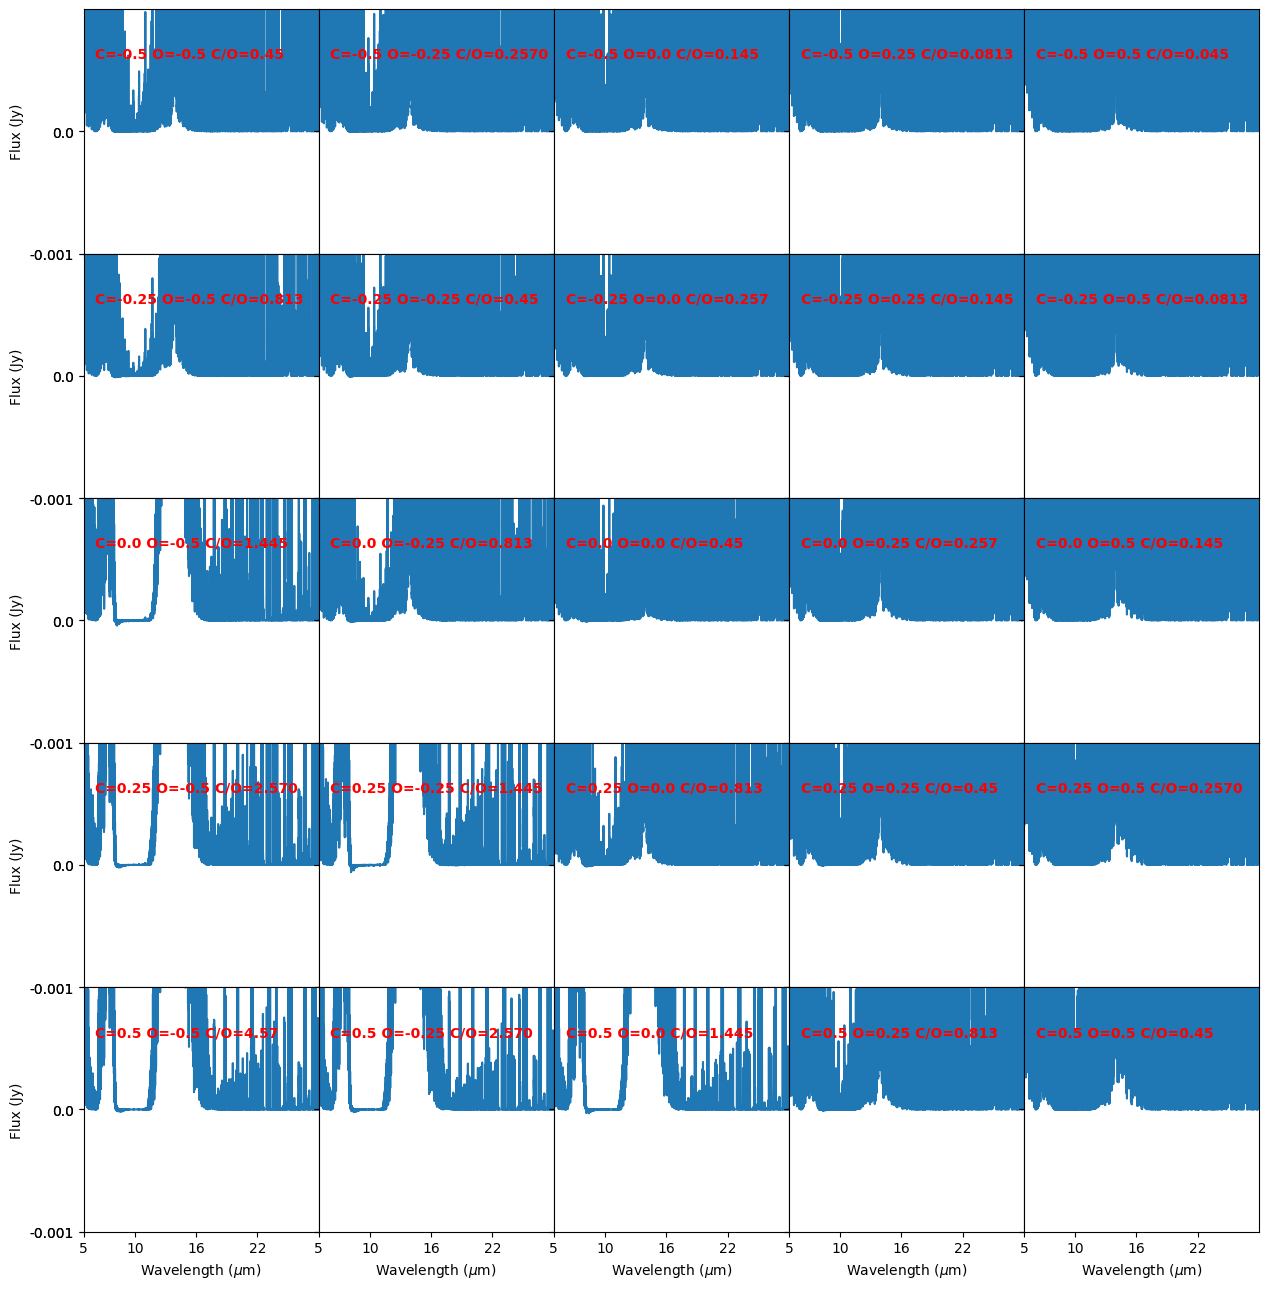

In [6]:
plot_FLiTs_spec(df, yrange=[-0.001, 0.001], savename='FLiTs_spectra.jpg')

# Prodimo Spectra
escape probability


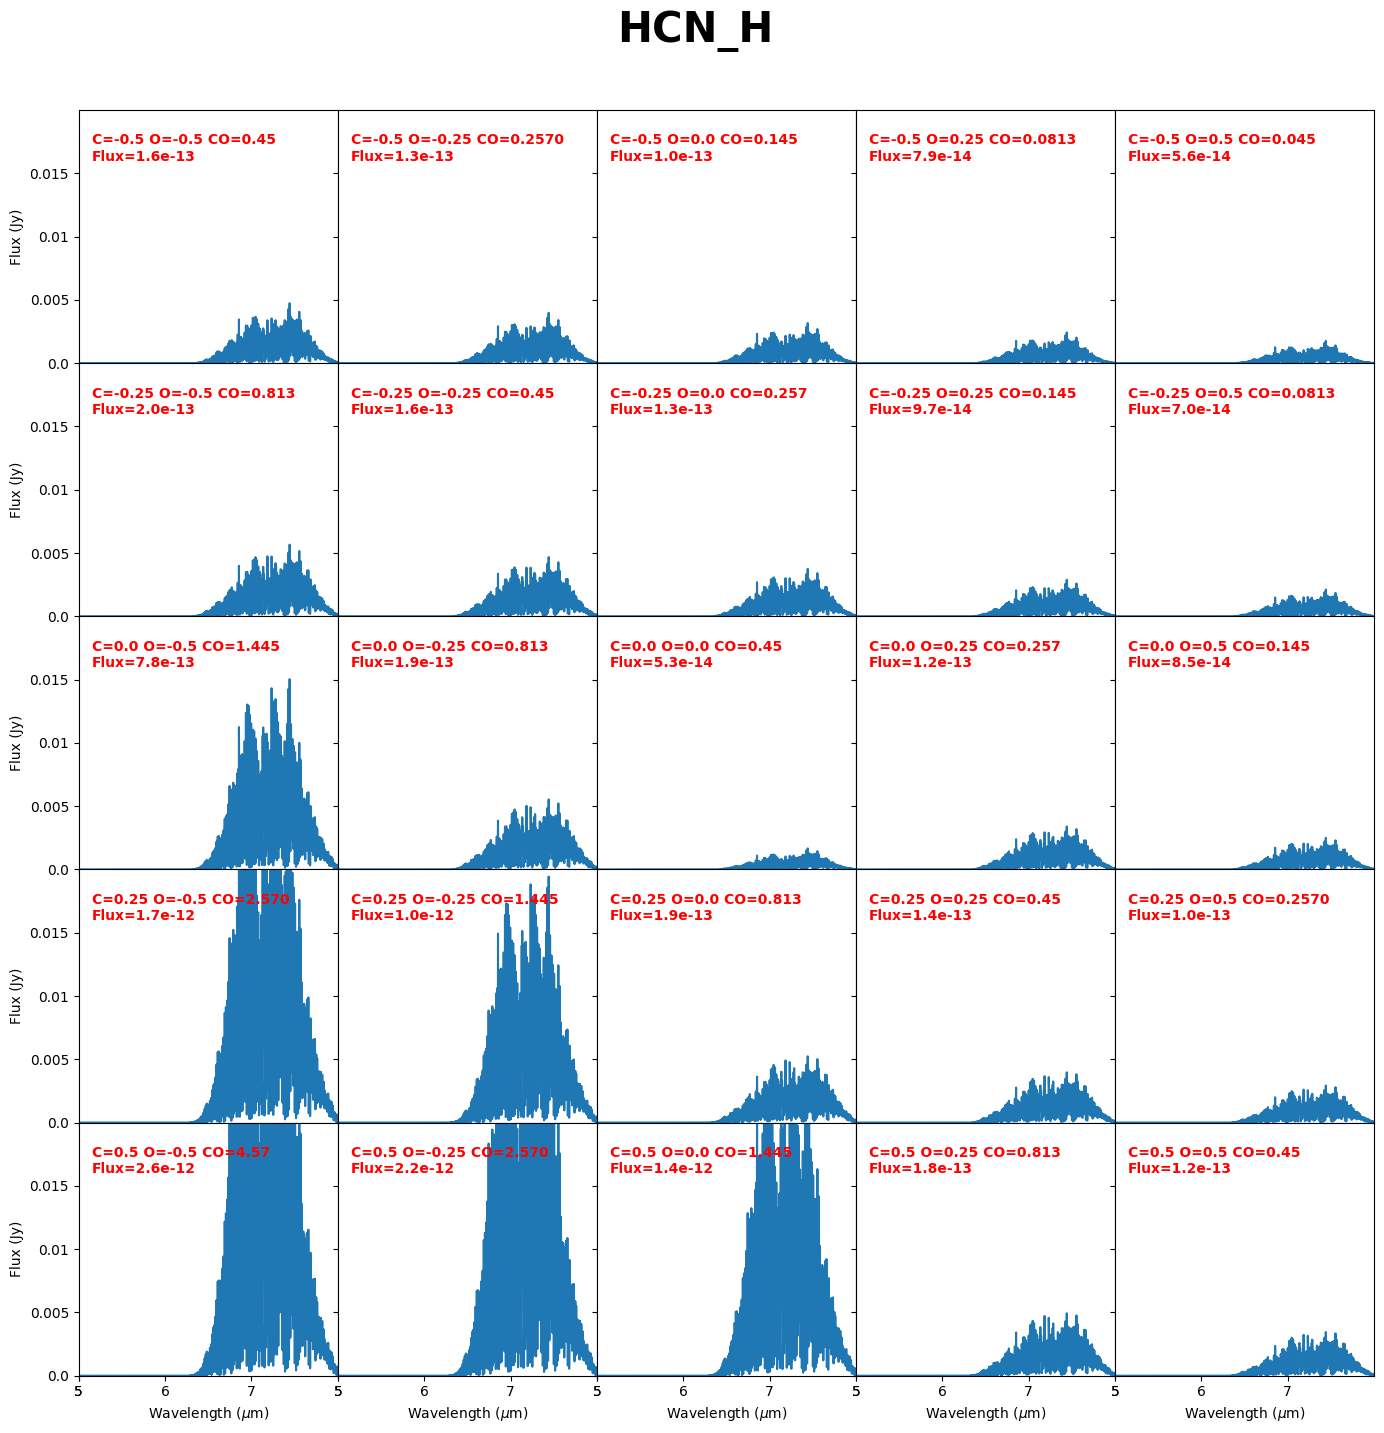

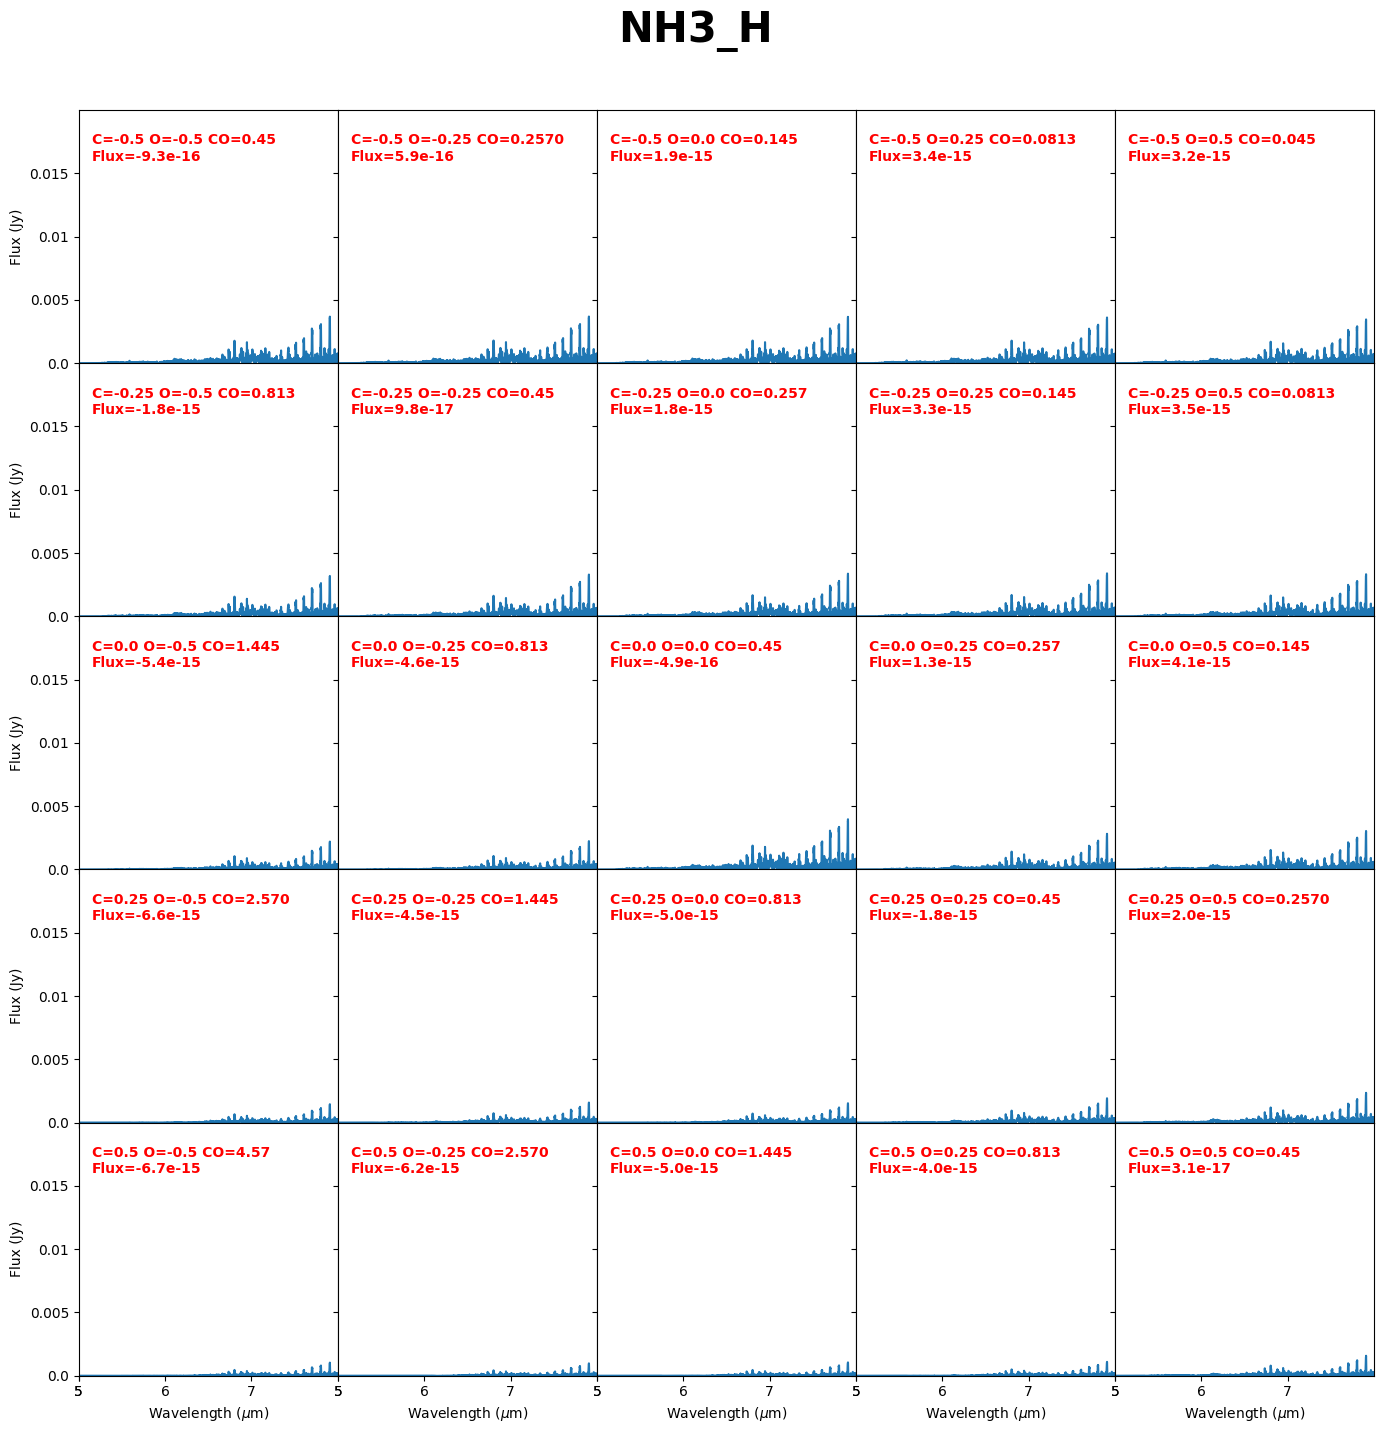

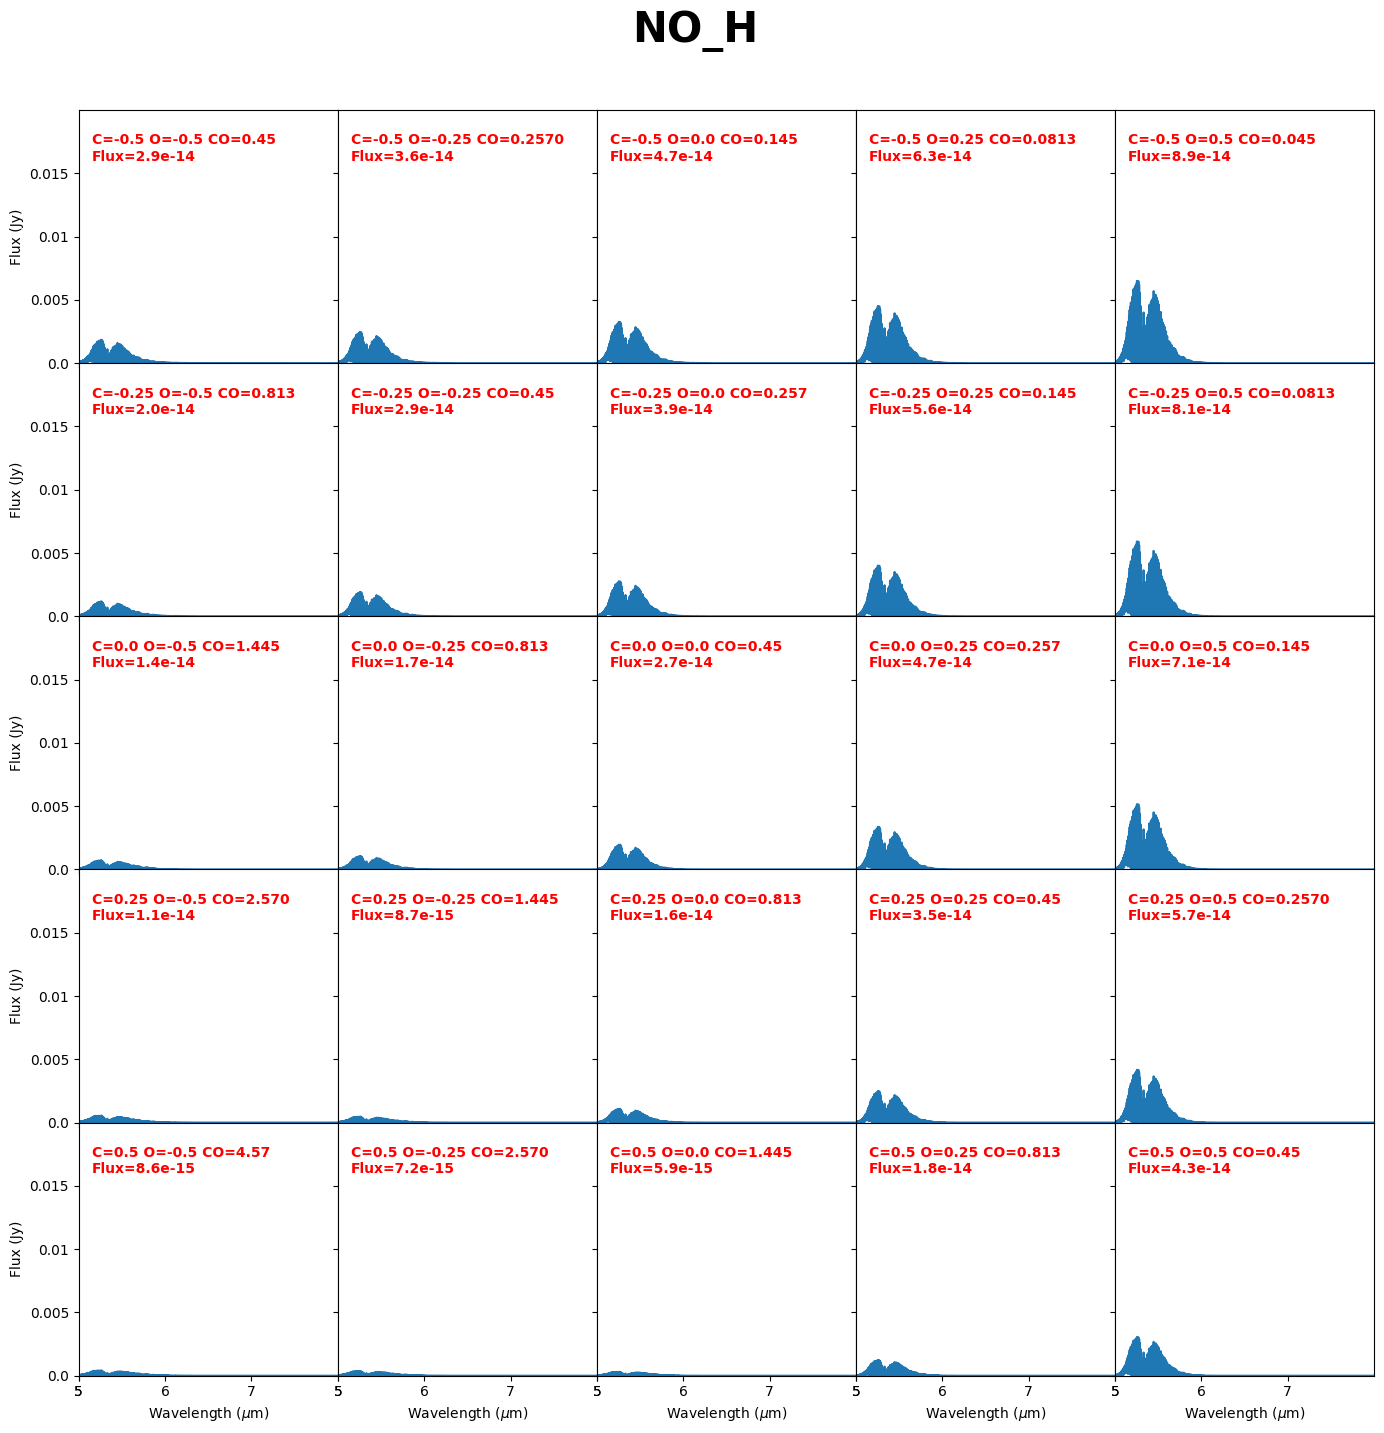

In [178]:
plt.close('all')
species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'S', 'o-H2', 'o-H2O', 'p-H2', 'p-H2O',
           'Ion']
species = ['HCN_H', 'NH3_H', 'NO_H']
for specie in species:
    plot_prodimo_specie(df, specie,xrange=[5,8], yrange=[0, 0.02])

In [130]:
# plt.close('all')
# species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'S', 'o-H2', 'o-H2O', 'p-H2', 'p-H2O',
#            'Ion']
# # species = ['C2H2_H']
# for specie in species:
#     fig = plt.figure(figsize=(15, 15))
#     gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
#     axes = gs.subplots(sharex='col', sharey='row').flatten()
#     for i, row in df.iterrows():
#         n_row, n_col = divmod(i, 5)
#         axes[i].plot(row['Prodimo Wavelength'], row[specie], label=row['Model Name'])
#         axes[i].text(wlrange[0] + (wlrange[1] - wlrange[0]) * 0.05, 0.9*flux_lim,
#                      f"C={row['C Value']} O={row['O Value']} CO={row['CO Value']} \nFlux={total_flux(row['Prodimo Wavelength'], row[specie]):.1e}", fontsize=10, color='red',
#                      weight='bold')
#         axes[i].set_xlim(wlrange)
#         axes[i].set_ylim([0, flux_lim])
#         if n_row == 4:
#             axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
#             axes[i].set_xticks([6, 12, 18, 24])
#             axes[i].set_xticklabels([6, 12, 18, 24])
#         if n_col == 0:
#             axes[i].set_ylabel("Flux (Jy)")
#             axes[i].set_yticks(np.linspace(0, 0.8*flux_lim, n_yticks))
#             axes[i].set_yticklabels(np.linspace(0, 0.8*flux_lim, n_yticks))
#     fig.suptitle(specie, fontsize=30, fontweight='bold', y=1.02)
#     plt.tight_layout()
#     plt.savefig('figures/' + specie + '_total_spec.pdf')
#     plt.show()

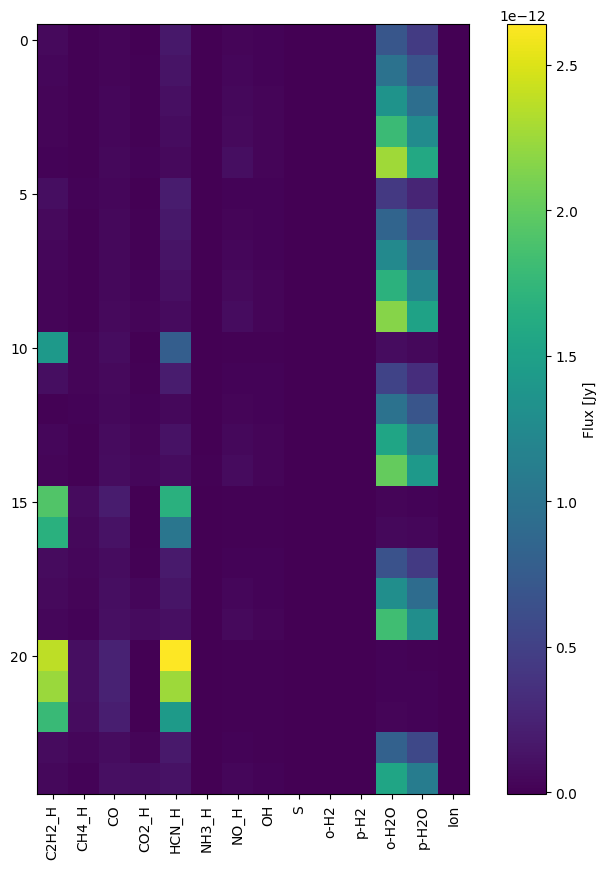

        C2H2_H  CH4_H    CO  CO2_H  HCN_H  NH3_H  NO_H    OH     S  o-H2  \
C2H2_H    1.00   0.77  0.43  -0.47   0.93  -0.76 -0.76 -0.79  0.32  0.31   
CH4_H     0.77   1.00  0.57  -0.34   0.72  -0.77 -0.77 -0.84  0.21  0.14   
CO        0.43   0.57  1.00   0.05   0.37  -0.38 -0.38 -0.43  0.35 -0.09   
CO2_H    -0.47  -0.34  0.05   1.00  -0.54   0.51  0.51  0.49 -0.45 -0.71   
HCN_H     0.93   0.72  0.37  -0.54   1.00  -0.76 -0.83 -0.83  0.31  0.37   
NH3_H    -0.76  -0.77 -0.38   0.51  -0.76   1.00  0.81  0.85 -0.19 -0.35   
NO_H     -0.76  -0.77 -0.38   0.51  -0.83   0.81  1.00  0.89 -0.19 -0.31   
OH       -0.79  -0.84 -0.43   0.49  -0.83   0.85  0.89  1.00 -0.17 -0.29   
S         0.32   0.21  0.35  -0.45   0.31  -0.19 -0.19 -0.17  1.00  0.50   
o-H2      0.31   0.14 -0.09  -0.71   0.37  -0.35 -0.31 -0.29  0.50  1.00   
p-H2      0.33   0.17 -0.09  -0.73   0.39  -0.38 -0.34 -0.31  0.46  0.95   
o-H2O    -0.79  -0.70 -0.29   0.64  -0.86   0.78  0.87  0.85 -0.29 -0.44   
p-H2O    -0.

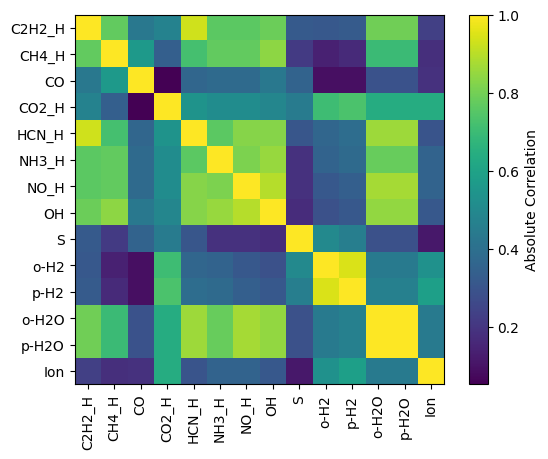

In [131]:
plt.close('all')
species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'S', 'o-H2', 'p-H2', 'o-H2O', 'p-H2O',
           'Ion']
data = []
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row['Prodimo Wavelength'], row[specie]))
    data.append(fluxes)
df_prodimo_flux = pd.DataFrame(data, columns=species)
plt.figure(figsize=(10, 10))
plt.imshow(df_prodimo_flux, cmap='viridis')
plt.xticks(ticks=np.arange(len(species)), labels=species, rotation=90)
plt.colorbar(label='Flux [Jy]')
plt.show()
print(df_prodimo_flux.corr(method='kendall').round(2))
plt.imshow(abs(df_prodimo_flux.corr(method='kendall')), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(species)), labels=species, rotation=90)
plt.yticks(ticks=np.arange(len(species)), labels=species)
plt.colorbar(label='Absolute Correlation')
plt.show()
# df_prodimo_flux.corr().to_csv('Prodimo_flux_correlation.csv', float_format="%.2f")

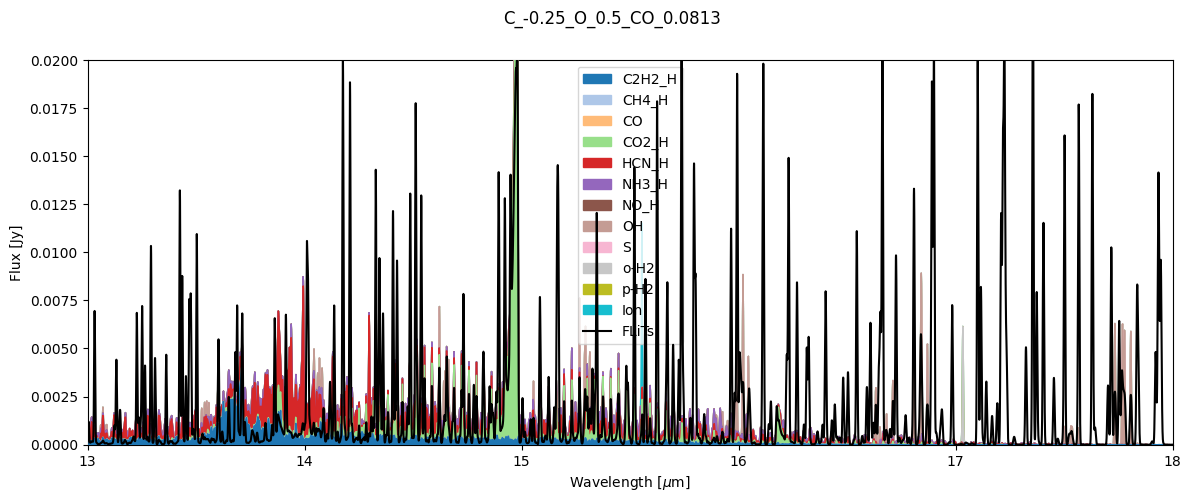

In [156]:
wlrange = [13, 16]
model = df['Model Name'][9]
species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'S', 'o-H2', 'p-H2', 'o-H2O', 'p-H2O',
           'Ion']
species = ['C2H2_H', 'CH4_H', 'CO', 'CO2_H', 'HCN_H', 'NH3_H', 'NO_H', 'OH', 'S', 'o-H2', 'p-H2', 'Ion']
plot_prodimo_spec(df, model, species=species, xrange=[13, 18], yrange=[0,0.02], plotFLiTs=True)

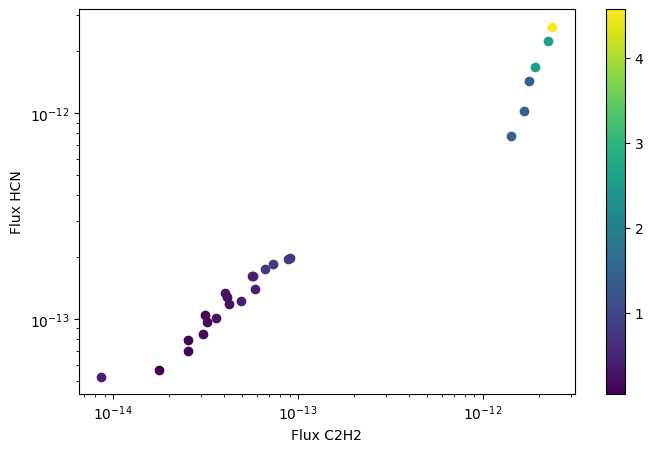

Correlation: 0.9333333333333331, P-value: 1.5136119705950535e-17


In [157]:
x = []
y = []
# norm = plt.Normalize(df_flux['CO'].min(), df_flux['CO'].max())
co_values = np.asarray([float(df.loc[df['Model Name'] == model, 'CO Value'].iloc[0]) for model in df['Model Name'].copy()])
norm = plt.Normalize(co_values.min(), co_values.max())
cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(8, 5))
for model in df['Model Name'].copy():
    wl = df.loc[df['Model Name'] == model, 'Prodimo Wavelength'].values[0].copy()
    HCN_flux = df.loc[df['Model Name'] == model, 'HCN_H'].values[0].copy()
    C2H2_flux = df.loc[df['Model Name'] == model, 'C2H2_H'].values[0].copy()
    x.append(total_flux(wl, C2H2_flux))
    y.append(total_flux(wl, HCN_flux))
    # y.append(calc_flux(wl, NH3_flux, [5, 9])+ calc_flux(wl, NH3_flux, [12, 18]))
    ax.scatter(x[-1], y[-1], color=cmap(norm(float(df.loc[df['Model Name'] == model, 'CO Value'].iloc[0]))))
ax.set_xlabel('Flux C2H2')
ax.set_ylabel('Flux HCN')
# ax.set_xlim(0, 0.5 * 1e-12)
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.show()
x = np.asarray(x)
y = np.asarray(y)

from scipy.stats import kendalltau, spearmanr, pearsonr
corr, p_value = kendalltau(x, y)
print(f"Correlation: {corr}, P-value: {p_value}")

100%|██████████| 25/25 [00:00<00:00, 95.96it/s] 


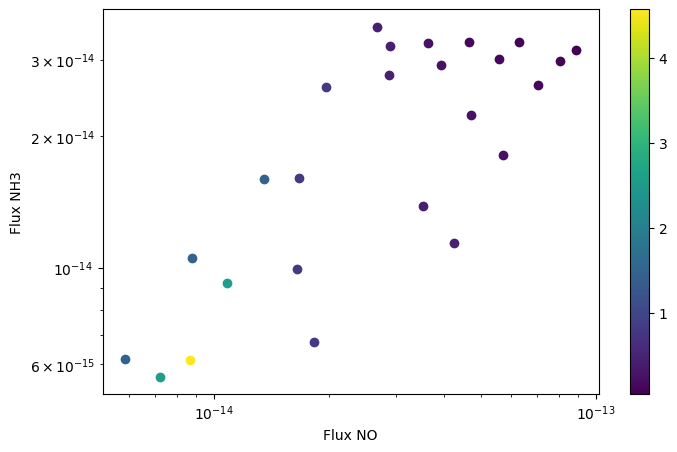

Correlation: 0.5133333333333333, P-value: 0.0001973957152927555


In [158]:
x = []
y = []
# norm = plt.Normalize(df_flux['CO'].min(), df_flux['CO'].max())
co_values = np.asarray([float(df.loc[df['Model Name'] == model, 'CO Value'].iloc[0]) for model in df['Model Name'].copy()])
norm = plt.Normalize(co_values.min(), co_values.max())
cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(8, 5))
for model in tqdm(df['Model Name'].copy()):
    wl = df.loc[df['Model Name'] == model, 'Prodimo Wavelength'].values[0].copy()
    NO_flux = df.loc[df['Model Name'] == model, 'NO_H'].values[0].copy()
    HCN_flux = df.loc[df['Model Name'] == model, 'HCN_H'].values[0].copy()
    NH3_flux = df.loc[df['Model Name'] == model, 'NH3_H'].values[0].copy()
    C2H2_flux = df.loc[df['Model Name'] == model, 'C2H2_H'].values[0].copy()
    CO2_flux = df.loc[df['Model Name'] == model, 'CO2_H'].values[0].copy()
    x.append(total_flux(wl, NO_flux))
    y.append(calc_flux(wl, NH3_flux, [5, 8]))
    # y.append(calc_flux(wl, NH3_flux, [5, 9])+ calc_flux(wl, NH3_flux, [12, 18]))
    ax.scatter(x[-1], y[-1], color=cmap(norm(float(df.loc[df['Model Name'] == model, 'CO Value'].iloc[0]))))
ax.set_xlabel('Flux NO')
ax.set_ylabel('Flux NH3')
# ax.set_xlim(0, 0.5 * 1e-12)
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.show()
x = np.asarray(x)
y = np.asarray(y)

from scipy.stats import kendalltau, spearmanr, pearsonr
corr, p_value = kendalltau(x, y)
print(f"Correlation: {corr}, P-value: {p_value}")

# FLiTs Data

In [135]:
# Spectral regions from Anderson et al. 2021
spectral_regions = {r'CO$_2$': [14.874, 15.014], r'C$_2$H$_2$': [13.553, 13.764], 'HCN': [13.837, 14.075],
                    r'H$_2$O': [17.190, 17.260], 'OH \n23 µm': [23.009, 23.308], 'OH \n27 µm': [27.308, 27.764],
                    r'CH$_4$': [5, 11]}
data = []
columns = list(spectral_regions.keys())
columns.extend(['C', 'O','CO'])
for model in tqdm(df['Model Name'].copy()):
    fluxes = []
    for key, value in spectral_regions.items():
        fluxes.append(calc_flux(df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy(), df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy(), value))
    fluxes.append(float(df.loc[df['Model Name'] == model, 'C Value'].values[0]))
    fluxes.append(float(df.loc[df['Model Name'] == model, 'O Value'].values[0]))
    fluxes.append(float(df.loc[df['Model Name'] == model, 'CO Value'].values[0]))
    data.append(fluxes)

df_flux = pd.DataFrame(data, columns=columns)

100%|██████████| 25/25 [00:02<00:00,  8.47it/s]


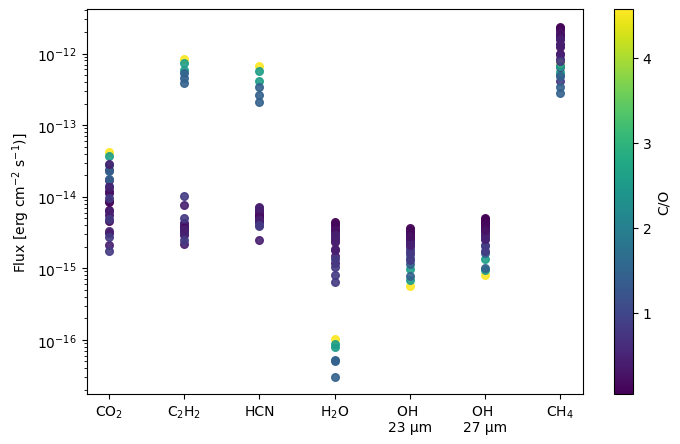

In [136]:
specie = 'CO'
norm = plt.Normalize(df_flux[specie].min(), df_flux[specie].max())
cmap = plt.cm.viridis

# Plot each column with colors based on the last column
fig, ax = plt.subplots(figsize=(8, 5))

for i, row in df_flux.iterrows():
    ax.scatter(np.arange(len(columns[:-3])), row[:-3], color=cmap(norm(row[specie])), alpha=0.9, s=30)

ax.set_xticks(np.arange(len(columns[:-3])))
ax.set_xticklabels(columns[:-3]) 
ax.set_yscale('log')
# Formatting
# ax.set_xlabel('Index')
ax.set_ylabel(r'Flux [erg cm$^{-2}$ s$^{-1}$)]')
# plt.title('Plot with Colormap Based on Last Column')
# plt.legend()
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('C/O')

plt.show()

              CO$_2$  C$_2$H$_2$       HCN    H$_2$O  OH \n23 µm  OH \n27 µm  \
CO$_2$      1.000000    0.160000  0.446667  0.013333   -0.193333   -0.320000   
C$_2$H$_2$  0.160000    1.000000  0.713333 -0.346667   -0.353333   -0.360000   
HCN         0.446667    0.713333  1.000000 -0.260000   -0.320000   -0.366667   
H$_2$O      0.013333   -0.346667 -0.260000  1.000000    0.780000    0.653333   
OH \n23 µm -0.193333   -0.353333 -0.320000  0.780000    1.000000    0.873333   
OH \n27 µm -0.320000   -0.360000 -0.366667  0.653333    0.873333    1.000000   
CH$_4$      0.093333   -0.253333 -0.166667  0.906667    0.700000    0.573333   

              CH$_4$  
CO$_2$      0.093333  
C$_2$H$_2$ -0.253333  
HCN        -0.166667  
H$_2$O      0.906667  
OH \n23 µm  0.700000  
OH \n27 µm  0.573333  
CH$_4$      1.000000  


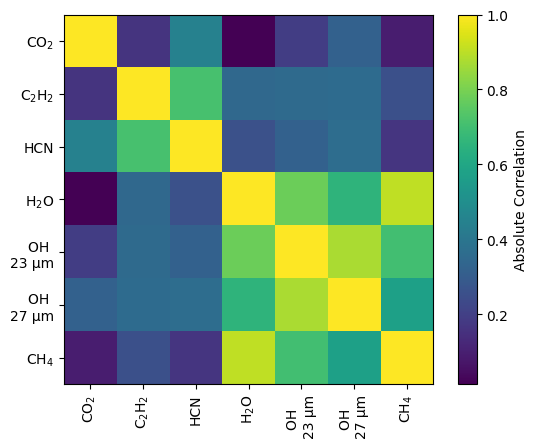

In [145]:
correlation_matrix = df_flux[list(spectral_regions.keys())].corr(method='kendall')
print(correlation_matrix)
plt.imshow(abs(correlation_matrix), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(columns[:-3])), labels=columns[:-3], rotation=90)
plt.yticks(ticks=np.arange(len(columns[:-3])), labels=columns[:-3])
plt.colorbar(label='Absolute Correlation')
plt.show()

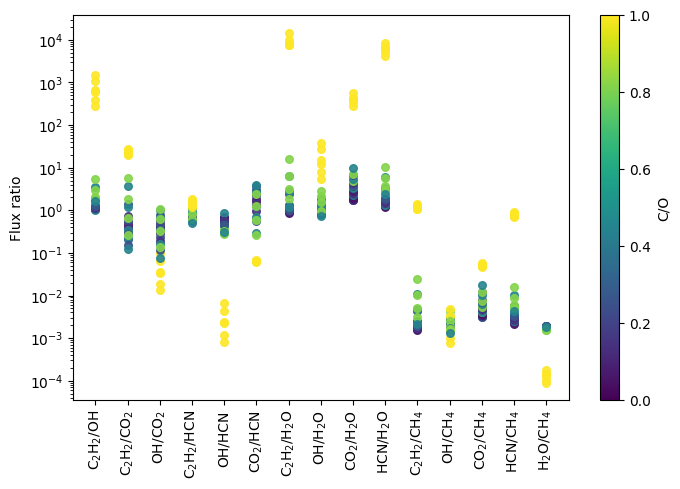

In [177]:
specie = 'CO'
norm = plt.Normalize(0, 1)
cmap = plt.cm.viridis

# Plot each column with colors based on the last column
fig, ax = plt.subplots(figsize=(8, 5))
ratios = ['C$_2$H$_2$/OH \n23 µm', 'C$_2$H$_2$/CO$_2$', 'OH \n23 µm/CO$_2$', 'C$_2$H$_2$/HCN', 'OH \n23 µm/HCN', 'CO$_2$/HCN', 'C$_2$H$_2$/H$_2$O', 'OH \n23 µm/H$_2$O', 'CO$_2$/H$_2$O', 'HCN/H$_2$O', 'C$_2$H$_2$/CH$_4$', 'OH \n23 µm/CH$_4$', 'CO$_2$/CH$_4$', 'HCN/CH$_4$', 'H$_2$O/CH$_4$']

for i, row in df_flux.iterrows():
    for index, ratio in enumerate(ratios):
        ax.scatter(np.arange(len(ratios))[index], row[ratio.split('/')[0]]/row[ratio.split('/')[1]], color=cmap(norm(row[specie])), alpha=0.9, s=30)

ratio_names = ['C$_2$H$_2$/OH', 'C$_2$H$_2$/CO$_2$', 'OH/CO$_2$', 'C$_2$H$_2$/HCN', 'OH/HCN', 'CO$_2$/HCN', 'C$_2$H$_2$/H$_2$O', 'OH/H$_2$O', 'CO$_2$/H$_2$O', 'HCN/H$_2$O', 'C$_2$H$_2$/CH$_4$', 'OH/CH$_4$', 'CO$_2$/CH$_4$', 'HCN/CH$_4$', 'H$_2$O/CH$_4$']
ax.set_xticks(np.arange(len(ratios)))
ax.set_xticklabels(ratio_names, rotation=90) 
ax.set_yscale('log')
# Formatting
# ax.set_xlabel('Index')
ax.set_ylabel(r'Flux ratio')
# plt.title('Plot with Colormap Based on Last Column')
# plt.legend()
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('C/O')

plt.show()

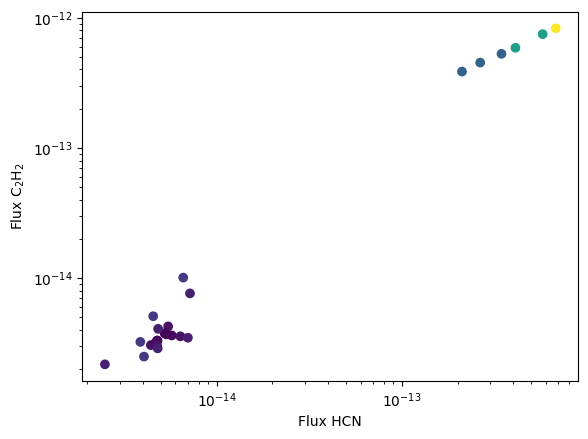

In [169]:
plt.scatter(df_flux['HCN'], df_flux['C$_2$H$_2$'], color=cmap(norm(df_flux['CO'])))
plt.xlabel('Flux HCN')
plt.ylabel('Flux C$_2$H$_2$')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [13]:
data = []
for model in df['Model Name'].copy():
    info = []
    info.append(model)
    model_flits = pread.read_FLiTs('./NH3/'+model, filename='specFLiTs1_NH3.out')
    info.append(model_flits.wl)
    info.append(model_flits.flux- model_flits.flux_cont)
    data.append(info)
    
NH3_df = pd.DataFrame(data, columns=['Model Name', 'FLiTs Wavelength', 'FLiTs Flux'])

READ: Reading File:  ./NH3/C_-0.5_O_-0.5_CO_0.45\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_-0.5_O_-0.25_CO_0.2570\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_-0.5_O_0.0_CO_0.145\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_-0.5_O_0.25_CO_0.0813\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_-0.5_O_0.5_CO_0.045\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_-0.25_O_-0.5_CO_0.813\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_-0.25_O_-0.25_CO_0.45\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_-0.25_O_0.0_CO_0.257\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_-0.25_O_0.25_CO_0.145\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_-0.25_O_0.5_CO_0.0813\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_0.0_O_-0.5_CO_1.445\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_0.0_O_-0.25_CO_0.813\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_0.0_O_0.0_CO_0.45\specFLiTs1_NH3.out  ...
READ: Reading File:  ./NH3/C_0.0_O_0.2

In [11]:
NH3_df

,Model Name,FLiTs Wavelength,FLiTs FLux
0,C_-0.5_O_-0.5_CO_0.45,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C_-0.5_O_-0.25_CO_0.2570,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C_-0.5_O_0.0_CO_0.145,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,C_-0.5_O_0.25_CO_0.0813,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,C_-0.5_O_0.5_CO_0.045,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,C_-0.25_O_-0.5_CO_0.813,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,C_-0.25_O_-0.25_CO_0.45,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,C_-0.25_O_0.0_CO_0.257,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,C_-0.25_O_0.25_CO_0.145,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,C_-0.25_O_0.5_CO_0.0813,"[4.91914026, 4.91915666, 4.91917307, 4.9191894...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


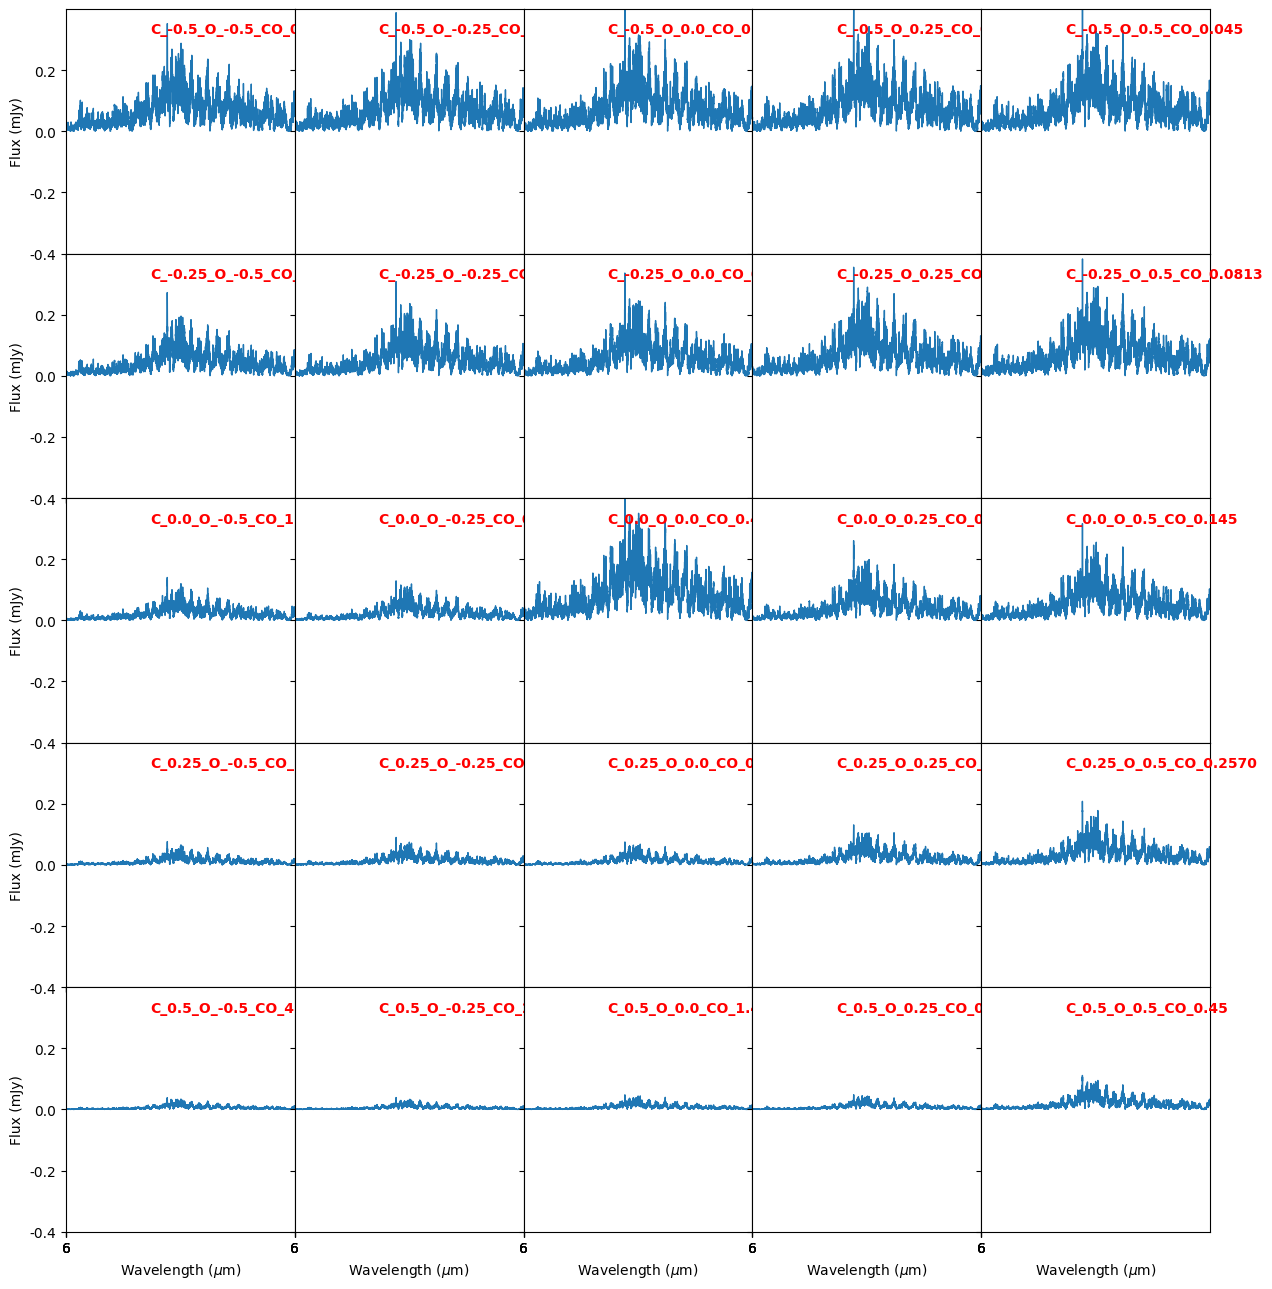

In [53]:
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[6.1,6.3]
yrange=[-0.4,0.4]
num_xticks = 5
num_yticks = 5
for i, row in NH3_df.iterrows():
    n_row, n_col = divmod(i, 5)
    axes[i].plot(row['FLiTs Wavelength'], row['FLiTs Flux']*1000, label=row['Model Name'], lw=1)
    axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.9,
                 row['Model Name'],
                 fontsize=10, color='red',
                 weight='bold')
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
        axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
    if n_col == 0:
        axes[i].set_ylabel("Flux (mJy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
plt.tight_layout()
plt.savefig('NH3_FLiTs.pdf')
plt.show()

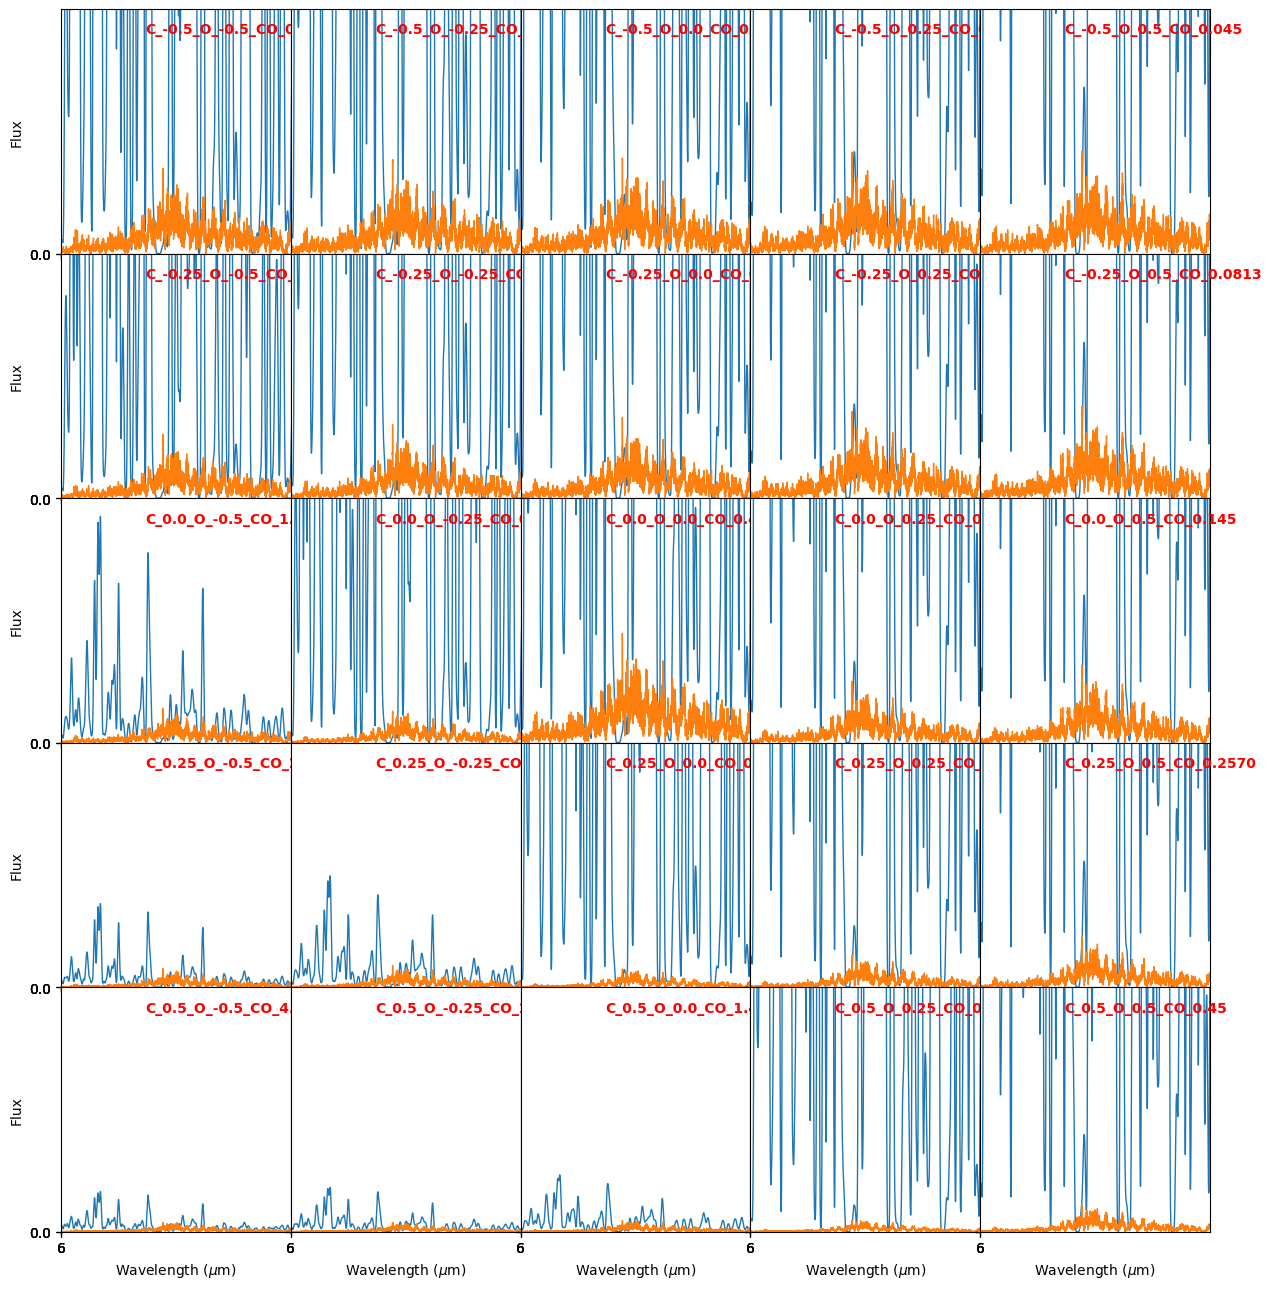

In [54]:
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[6.1, 6.3]
yrange=[0, 0.001]
num_xticks = 5
num_yticks = 5
for i, row in NH3_df.iterrows():
    n_row, n_col = divmod(i, 5)
    total_FLiTs_flux = df.loc[df['Model Name'] == row['Model Name'], 'FLiTs Flux'].values[0].copy()
    total_FLiTs_wl = df.loc[df['Model Name'] == row['Model Name'], 'FLiTs Wavelength'].values[0].copy()
    interp_NH3_flux = np.interp(total_FLiTs_wl, row['FLiTs Wavelength'], row['FLiTs Flux'])
    axes[i].plot(total_FLiTs_wl, total_FLiTs_flux, lw=1)
    axes[i].plot(total_FLiTs_wl, interp_NH3_flux, lw=1)
    axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.9,
                 row['Model Name'],
                 fontsize=10, color='red',
                 weight='bold')
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")  # Bottom row
        axes[i].set_xticks(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
        axes[i].set_xticklabels(np.linspace(xrange[0], xrange[1], num_xticks, dtype=int)[:-1])
    if n_col == 0:
        axes[i].set_ylabel("Flux")
        axes[i].set_yticks(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 10, yrange[1] * 10, num_yticks, dtype=int)[:-1] / 10)
plt.tight_layout()
plt.show()